In [86]:
# %load "../lib/statistic_tools/fitting.py"
#!/usr/bin/env python3

import numpy as np
import scipy.optimize as opt
from statistic_tools.general import bootstrap
import time

def cost(param, index, chifitter):
    xdata = chifitter.xdata
    ydata = chifitter.ydata
    ffunc = chifitter.ffunc
    nmin = chifitter.nmin
    nmax = chifitter.nmax
    W = chifitter.W

    return np.sum([(ydata[index, ni]-ffunc(xdata[ni], *param))*W[ni,nj]*
                    (ydata[index, nj]-ffunc(xdata[nj], *param))
                    for ni in range(nmin,nmax+1) for nj in range(nmin,nmax+1)])


class Chi2fitter:

    def __init__(self, xdata, ydata, ffunc, param0, nmin=0, nmax=-1, tol=1e-6,
                 W=None, opt_method='BFGS', options={}):
        if xdata.shape[0] != ydata.shape[1]:
            raise ValueError("first dim of xdata and ydata are expected to be"
                             +f"the same, got {xdata.shape} and {ydata.shape}")
        self.xdata = xdata
        self.ydata = ydata
        self.Nd, self.Nt = ydata.shape

        self.ffunc = ffunc
        self.param0 = param0
        self.param = param0

        if 0 <= nmin < self.Nt:
            self.nmin = nmin
        else:
            raise ValueError(f"nmin have to lie between 0 and Nt-1, got {nmin}")

        if nmin < nmax < self.Nt:
            self.nmax = nmax
        elif nmax == -1:
            self.nmax = self.Nt-1
        else:
            raise ValueError(f"nmax have to lie between nmin and Nt-1, got {nmax}")

        if W == None:
            self.W = self._calc_cov()
        else:
            if W.shape != (self.Nt, self.Nt):
                raise ValueError(f"W has the wrong shape, expected ({self.Nt},{self.Nt}), got {W.shape}")
            else:
                self.W = W

        self.tol = tol
        self.opt_method='Nelder-Mead'
        self.options=options

    def _calc_cov(self):
        means = np.mean(self.ydata, axis=0)
        print(means)

        W = np.zeros((self.Nt, self.Nt), dtype=np.double)
        for ni in range(self.Nt):
            for nj in range(ni, self.Nt):
                tmp = 1/self.Nd *  np.mean([(self.ydata[i, ni]-means[ni])*
                                            (self.ydata[i, nj]-means[nj])
                                            for i in range(self.Nd)
                                           ])

                W[ni, nj] = tmp**(-1)
                W[nj, ni] = tmp**(-1)

        return W

    def _single_index_fit(self, index):

        param = self.param0

        sol = opt.minimize(cost, param, args=(index, self),
                           method=self.opt_method, tol=self.tol, 
                           options=self.options)

        return sol.x, sol.fun

    def evaluate(self, verbose=True):
        vals = np.zeros((self.Nd, self.param.shape[0]), dtype=np.double)
        funs = np.zeros((self.Nd, ), dtype=np.double)
        if not verbose: 
            print('Start fitting ...')
        TIME_START = time.time()

        for index in range(self.Nd):
            if not verbose:
                print(f'sample {index+1:5d}/{self.Nd:d}', end='\t')
            param, fun = self._single_index_fit(index)
            if not verbose: print(f'{time.time()-TIME_START:6.3f} [sec]')
            vals[index,:] = param
            funs[index] = fun

        params, params_err = bootstrap(vals)
        av_fit_error = np.mean(funs)
        
        if not verbose: 
            print(f'DONE IN {time.time()-TIME_START:6.3f} [sec]')
            return params, params_err, av_fit_error
        
        return params, params_err


## Create Test Sample

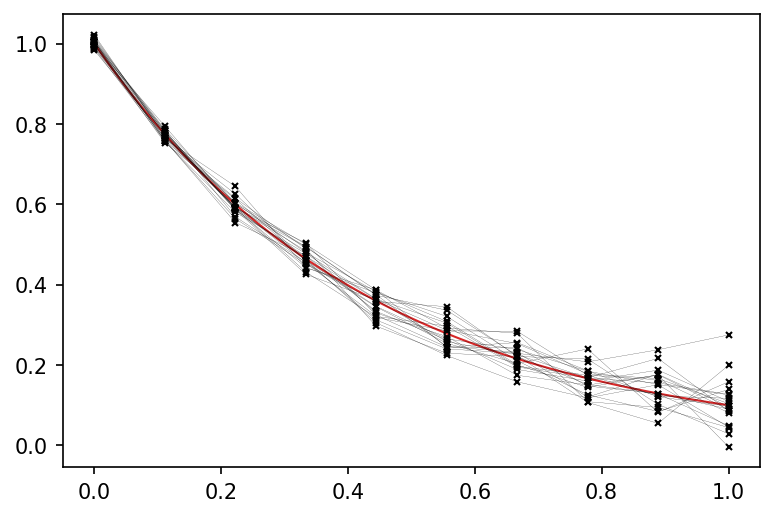

In [87]:
import matplotlib.pyplot as plt

def func(x, A, E):
    return A * np.exp(-E*x)


Nd = 20
A = 1.0
E = 2.3


rng = np.random.default_rng(42)
xvals = np.linspace(0,1,10)
_yvals = func(xvals, A, E)

yvals = np.zeros((Nd, xvals.shape[0]), dtype=np.double)
for i in range(Nd):
    yvals[i,:] = _yvals + rng.normal(loc=0.0, scale=0.05*xvals+0.01, size=_yvals.shape)
    
# Plot the sample
fig, ax = plt.subplots(1,1,dpi=150)
xvals_ = np.linspace(0,1,100)
ax.plot(xvals_, func(xvals_, A, E), lw=1, color='tab:red', ls='-')
for i in range(Nd):
    ax.plot(xvals, yvals[i,:], lw=.1, color='black', marker='x', markersize=3)
plt.show()


## Test Class instances

In [88]:
param0 = np.array([2.0, 3.0])
fitter = Chi2fitter(xvals, yvals, func, param0, opt_method='BFGS')
fitter.evaluate(verbose=False)

[1.00132268 0.77111941 0.59438042 0.46771167 0.34825778 0.27598967
 0.22200749 0.16171945 0.14400036 0.10319874]
Start fitting ...
sample     1/20	 0.109 [sec]
sample     2/20	 0.208 [sec]
sample     3/20	 0.320 [sec]
sample     4/20	 0.435 [sec]
sample     5/20	 0.544 [sec]
sample     6/20	 0.652 [sec]
sample     7/20	 0.757 [sec]
sample     8/20	 0.856 [sec]
sample     9/20	 0.974 [sec]
sample    10/20	 1.073 [sec]
sample    11/20	 1.174 [sec]
sample    12/20	 1.286 [sec]
sample    13/20	 1.390 [sec]
sample    14/20	 1.495 [sec]
sample    15/20	 1.587 [sec]
sample    16/20	 1.704 [sec]
sample    17/20	 1.820 [sec]
sample    18/20	 1.929 [sec]
sample    19/20	 2.037 [sec]
sample    20/20	 2.142 [sec]
DONE IN  2.144 [sec]


(array([1.00401238, 2.33216115]),
 array([0.0105118 , 0.04414128]),
 -6853.1296373614505)

In [107]:
param0 = np.array([2.0, 3.0])
fitter = Chi2fitter(xvals, yvals, func, param0, opt_method='Nelder-Mead')
param, errs, _ = fitter.evaluate(verbose=False)
print(param)

[1.00132268 0.77111941 0.59438042 0.46771167 0.34825778 0.27598967
 0.22200749 0.16171945 0.14400036 0.10319874]
Start fitting ...
sample     1/20	 0.118 [sec]
sample     2/20	 0.217 [sec]
sample     3/20	 0.331 [sec]
sample     4/20	 0.450 [sec]
sample     5/20	 0.552 [sec]
sample     6/20	 0.655 [sec]
sample     7/20	 0.758 [sec]
sample     8/20	 0.855 [sec]
sample     9/20	 0.975 [sec]
sample    10/20	 1.073 [sec]
sample    11/20	 1.171 [sec]
sample    12/20	 1.276 [sec]
sample    13/20	 1.380 [sec]
sample    14/20	 1.477 [sec]
sample    15/20	 1.571 [sec]
sample    16/20	 1.682 [sec]
sample    17/20	 1.799 [sec]
sample    18/20	 1.907 [sec]
sample    19/20	 2.008 [sec]
sample    20/20	 2.108 [sec]
DONE IN  2.109 [sec]
[1.00401238 2.33216115]


[0.26254299 0.26093232 0.24217317 0.29664953 0.23413084 0.23335221
 0.31224087 0.14752684        nan]
(9,)


<ipython-input-118-01c57acaa998>:4: RuntimeWarning: invalid value encountered in log
  eff_mass, err_mass = bootstrap(np.log(yvals[:,:-1]/yvals[:,1:]))


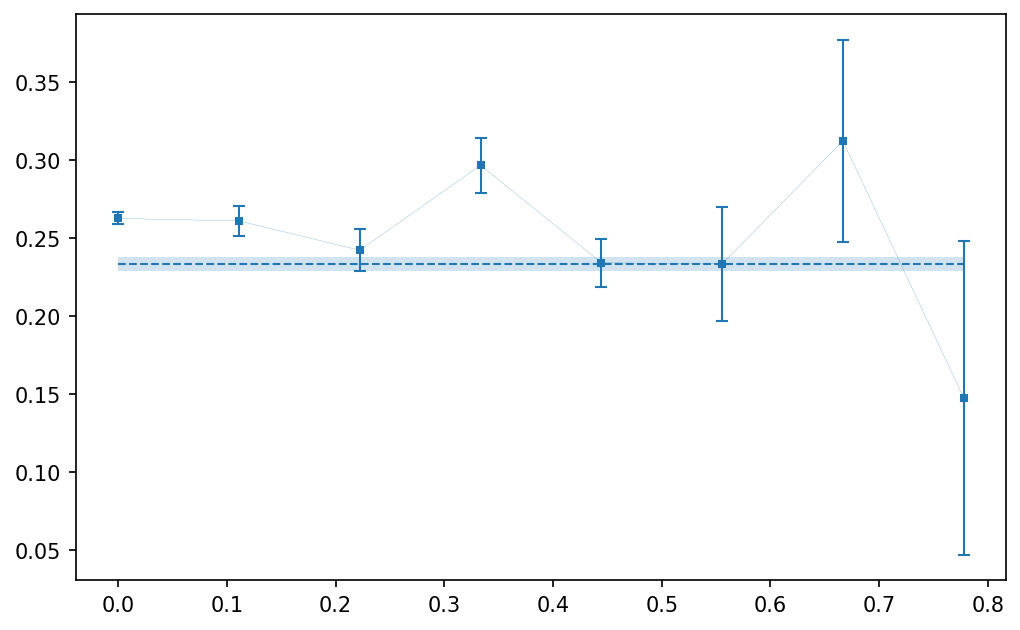

In [118]:
from statistic_tools.general import bootstrap

fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=150)
eff_mass, err_mass = bootstrap(np.log(yvals[:,:-1]/yvals[:,1:]))
print(eff_mass)
print(eff_mass.shape)
ax.errorbar(xvals[:-2], eff_mass[:-1], yerr=err_mass[:-1], lw=.1, marker='s', markersize=3, capsize=3,elinewidth=1)
nxvals = xvals[:-2].shape[0]
ax.fill_between(xvals[:-2], [(param[1]+errs[1])*0.1]*nxvals, [(param[1]-errs[1])*0.1]*nxvals, alpha=.2)
ax.plot(xvals[:-2], [param[1]*0.1]*nxvals, ls='--', color='tab:blue',lw=1)
plt.show()

In [110]:
np.log(yvals[1,:-1]/yvals[1,1:])

array([ 0.24880991,  0.26873547,  0.1951781 ,  0.27723819,  0.42043057,
        0.06026831,  0.65613534, -0.38800885,  0.60030216])